## UCL COMP0029 Individual Project for Year 3 BSc
### Robust Robotic Grasping Utilising Touch Sensing - Baseline Approach Notebook
This notebook contains the code for developing a baseline approach to grasping using classifiers: given some combinations of tactile data, end effector poses relative to the robot hand (visual data), etc., determine whether these constraints will produce a successful/unsuccessful grasp.

### 1. Load packages

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

Set device for `PyTorch` training

In [256]:
# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Empty PyTorch cache

In [257]:
gc.collect()
torch.cuda.empty_cache()

### 2. Load datasets

To collect data for this experiment, you can run the "Collect Sensory Data" button in the Pybullet simulation. This generates a predefined number of Gaussian grasps randomly generated from a base hand pose. Each individual grasp is considered as an individual experiment, and the data collected from this experiment is split into four, each stored in its own dataset.

For all object models used in this experiment, each object has 4 datasets which include:
- `depth_ds.npy` which stores the depth tactile data from the mounted DIGIT sensors
- `color_ds.npy` which stores the colored (RGB) version of the depth tactile data from the mounted DIGIT sensors
- `poses_ds.npy` which stores the randomly-generated 6d hand poses from the simulation
- `outcomes_ds.npy` which stores the outcomes of each random pose

In [258]:
object_name = "block"      # object_name should be in [bottle, block]

# Construct the relative paths of each dataset and load them into the notebook
depth_ds_file_path = object_name + "_ds/depth_ds.npy"
depth_ds = np.load(depth_ds_file_path)

color_ds_file_path = object_name + "_ds/color_ds.npy"
color_ds = np.load(color_ds_file_path)

poses_ds_file_path = object_name + "_ds/poses_ds.npy"
poses_ds = np.load(poses_ds_file_path)

grasp_outcomes_ds_file_path = object_name + "_ds/grasp_outcomes.npy"
grasp_outcomes_ds = np.load(grasp_outcomes_ds_file_path)

These datasets should all be in the form of $(N\times...)$ where $N$ is the number of examples:

In [259]:
print(f"Shape of depth_ds: {depth_ds.shape}")
print(f"Shape of color_ds: {color_ds.shape}")
print(f"Shape of poses_ds: {poses_ds.shape}")
print(f"Shape of grasp_outcomes_ds: {grasp_outcomes_ds.shape}")

Shape of depth_ds: (1587, 2, 160, 120)
Shape of color_ds: (1587, 2, 160, 120, 3)
Shape of poses_ds: (1587, 6)
Shape of grasp_outcomes_ds: (1587,)


Additionally, we confirm the number of successful and unsuccessful grasps recorded. This helps us in the next section to determine how many examples we should include for each class in order to produce a balanced dataset.

In [260]:
print(f"# of sucessesful grasps: {(grasp_outcomes_ds == 1).sum()}")
print(f"# of unsuccessful grasps: {(grasp_outcomes_ds == 0).sum()}")

# of sucessesful grasps: 926
# of insuccessful grasps: 661


### 3. Creating trainable dataset

We sample $N$ examples from each class label (successful and unsuccessful grasps) to reduce the computational cost.

In [261]:
def sample_data(depth_ds, color_ds, poses_ds, outcomes_ds, no_of_examples):
    d, c, p, o = [], [], [], []
    for label in np.unique(outcomes_ds):
        indices = np.where(outcomes_ds == label)[0]

        for i in range(no_of_examples):
            d.append(depth_ds[indices[i]])
            c.append(color_ds[indices[i]])
            p.append(poses_ds[indices[i]])
            o.append(outcomes_ds[indices[i]])
    
    depth_ds = torch.from_numpy(np.array(d))
    color_ds = torch.from_numpy(np.array(c))
    poses_ds = torch.from_numpy(np.array(p))
    outcomes_ds = torch.from_numpy(np.array(o))
    return depth_ds, color_ds, poses_ds, outcomes_ds

Sample $N$ samples, where $N$ is defined in the `no_of_examples` argument of the `sample_data` function.

In [262]:
depth_ds, color_ds, poses_ds, grasp_outcomes_ds = sample_data(depth_ds, color_ds, poses_ds, grasp_outcomes_ds, no_of_examples=400)

In [263]:
print(f"Shape of depth_ds: {depth_ds.shape}")
print(f"Shape of color_ds: {color_ds.shape}")
print(f"Shape of poses_ds: {poses_ds.shape}")
print(f"Shape of grasp_outcomes_ds: {grasp_outcomes_ds.shape}")

Shape of depth_ds: torch.Size([800, 2, 160, 120])
Shape of color_ds: torch.Size([800, 2, 160, 120, 3])
Shape of poses_ds: torch.Size([800, 6])
Shape of grasp_outcomes_ds: torch.Size([800])


#### 3a. Preprocessing

We define some reusable functions for later:

In [264]:
def normalize(tensor):
    mean = torch.mean(tensor, dim=0)
    std = torch.std(tensor, dim=0)
    return (tensor - mean) / std

In [265]:
def downsample_2d_tensor(tensor, factor=2):
    return torch.nn.functional.avg_pool2d(tensor.unsqueeze(0), kernel_size=factor, stride=factor, padding=0).squeeze(0)

def downsample_3d_tensor(tensor, factor=2):
    pooling_kernel = 2
    pooling_layer = torch.nn.AvgPool2d(kernel_size=pooling_kernel, stride=pooling_kernel)
    downsampled_tensor = pooling_layer(tensor.permute(0, 3, 1, 2))
    downsampled_tensor = downsampled_tensor.permute(0, 2, 3, 1)
    
    return downsampled_tensor

Since each tactile reading (depth and color) is a pair of images (one on each finger), we concatenate them together as a single 160x240 image.

In [266]:
depth_ds = torch.cat([depth_ds[:, 0, :, :], depth_ds[:, 1, :, :]], dim=2)
print(depth_ds.shape)
color_ds = torch.cat([color_ds[:, 0, :, :, :], color_ds[:, 1, :, :, :]], dim=2)
print(color_ds.shape)

torch.Size([800, 160, 240])
torch.Size([800, 160, 240, 3])


[Optional]: If the resulting tensors from concatenation are too large, consider downsampling them using the following functions.

In [267]:
# depth_ds = downsample_2d_tensor(depth_ds)
# color_ds = downsample_3d_tensor(color_ds)
# print(depth_ds.shape, color_ds.shape)

#### 3b. Visualisating datasets

Here we visualise random samples of depth and color (tactile) data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

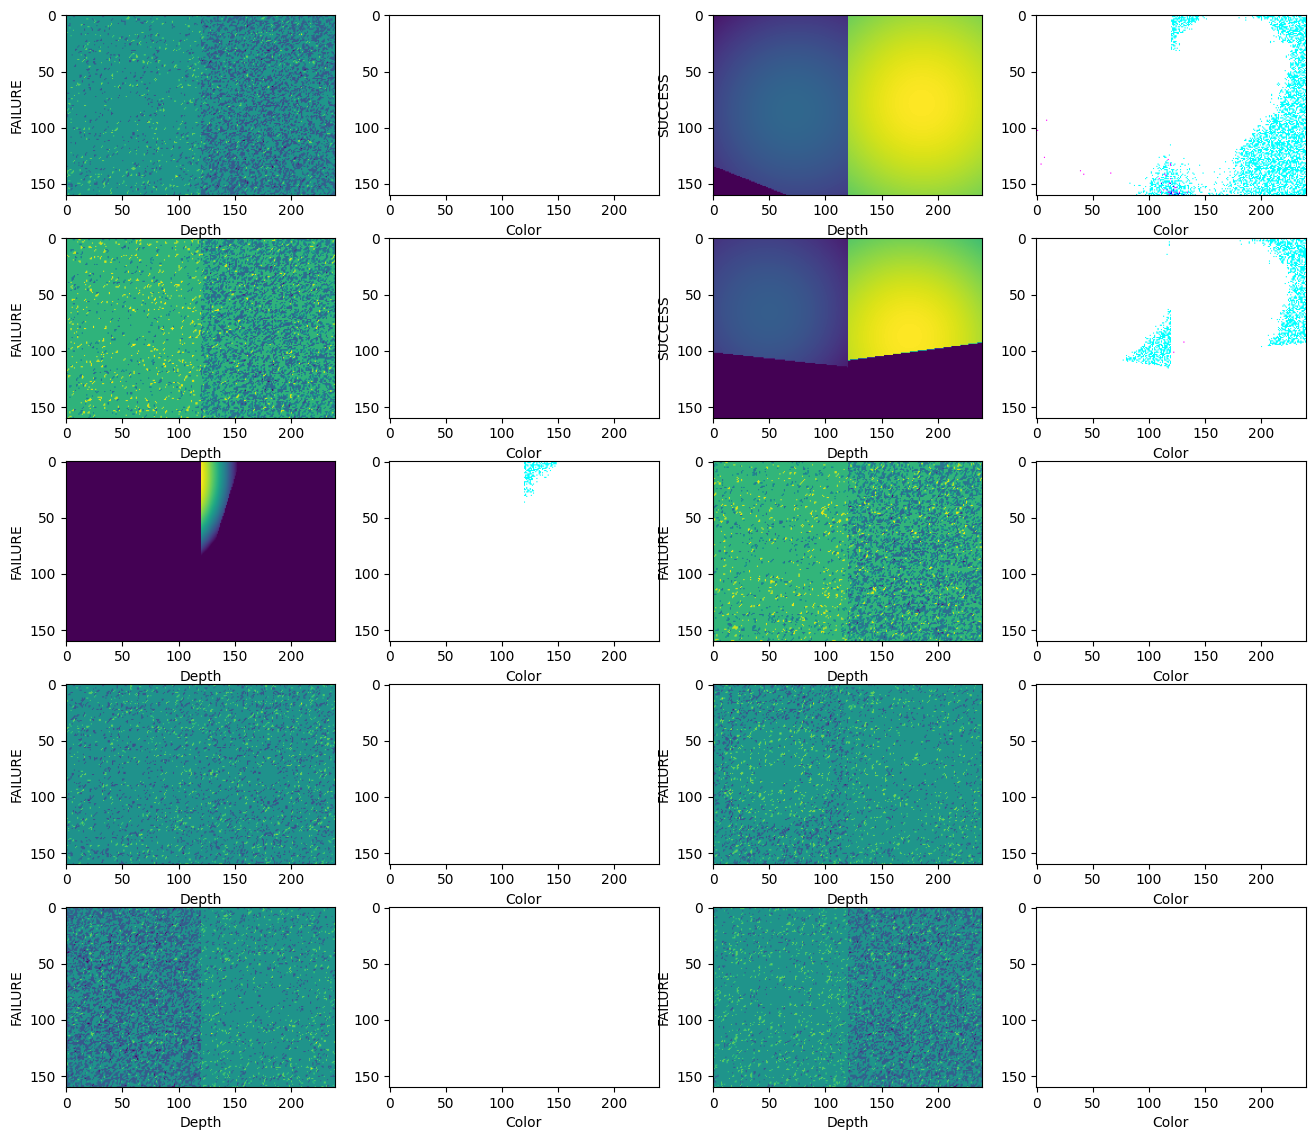

In [268]:
rand_indices = np.random.choice(len(depth_ds), size=10)
cols = 4
rows = 5
fig = plt.figure(figsize=(16, 14))

for i in range(rows*cols):
    fig.add_subplot(rows, cols, i+1)
    if i % 2 == 0:
        plt.xlabel("Depth")
        plt.ylabel("SUCCESS" if grasp_outcomes_ds[rand_indices[i//2]].item() == 1.0 else "FAILURE")
        plt.imshow(np.array(depth_ds[rand_indices[i//2]]))
    elif i % 2 == 1:
        plt.xlabel("Color")
        plt.imshow(np.array(color_ds[rand_indices[i//2]]))
plt.show()

Plot the end effector poses to investigate if we can simply visualise a clear decision boundary between successful & unsuccessful grasps

In [269]:
### Helper function to calculate approach vectors of a 6D pose
def calc_approach_vector(coord):
    R = np.array([[np.cos(coord[5])*np.cos(coord[4]), np.cos(coord[5])*np.sin(coord[4])*np.sin(coord[3])-np.sin(coord[5])*np.cos(coord[3]), np.cos(coord[5])*np.sin(coord[4])*np.cos(coord[3])+np.sin(coord[5])*np.sin(coord[3])],
              [np.sin(coord[5])*np.cos(coord[4]), np.sin(coord[5])*np.sin(coord[4])*np.sin(coord[3])+np.cos(coord[5])*np.cos(coord[3]), np.sin(coord[5])*np.sin(coord[4])*np.cos(coord[3])-np.cos(coord[5])*np.sin(coord[3])],
              [-np.sin(coord[4]), np.cos(coord[4])*np.sin(coord[3]), np.cos(coord[4])*np.cos(coord[3])]])
    return R.T

The following code only works for the block object. It is only for demonstration purposes.

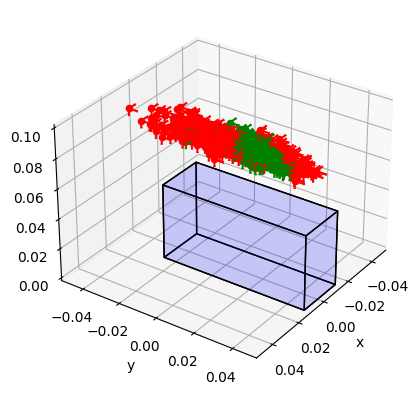

In [270]:
Z_PADDING = 0.15        # Adjust for visualisation of end poses

plot = plt.figure()
ax = plot.add_subplot(projection='3d')
ax.axes.set_xlim3d(-0.05, 0.05)
ax.axes.set_ylim3d(-0.05, 0.05)
ax.axes.set_zlim3d(0, 0.1)


# Plot hand poses with finger skeleton
for i in range(len(poses_ds)):
    # Calculate approach vectors and cartesian coordinates
    pose = poses_ds[i]
    x, y, z = pose[0], pose[1], pose[2]
    z -= Z_PADDING * 1.65
    av = calc_approach_vector(pose)
    # Color code the outcome
    outcome = grasp_outcomes_ds[i]
    color = 'green' if outcome == 1 else 'red'
    for j in range(3):
        ax.quiver(x, y, z, av[j, 0], av[j, 1], av[j, 2], color=color, length=0.005, arrow_length_ratio=0.1)
    ax.scatter(x, y, z, color=color)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# Draw block object
def plot_cube(cube_definition, ax):
    cube_definition_array = [np.array(list(item)) for item in cube_definition]
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]
    points = np.array(points)
    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))
    ax.add_collection3d(faces)
    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)
    # ax.set_aspect('equal')
    
# Dimensions of the block object: (W=0.025, H=0.05, D=0.05)
# (0,0,0), (0,1,0), (1,0,0), (0,0,1) -> unit cube
cube_definition = [(-0.0125, -0.025, 0), (0.0125, -0.025, 0), (-0.0125, 0.05, 0), (-0.0125, -0.025, 0.05)]
plot_cube(cube_definition, ax)

# Display the plot at different angles
ax.view_init(elev=30, azim=35, roll=0)

If the green and red points are mixed up together, it proves that there is a problem when generating the random poses.

#### 3c. Normalising datasets

We also normalize the images such that it won't over-influence the weights of our models:

In [271]:
depth_ds = normalize(depth_ds)
color_ds = normalize(color_ds)
poses_ds = normalize(poses_ds)
poses_ds = torch.from_numpy(np.nan_to_num(poses_ds))

### 4. Data Transformation/Feature Engineering for Model Training
We now train various logistic regression models in `sklearn`, using different data representations (tactile, visual, both) and processing techniques (raw, PCA, CNN). This gives us 9 unique models to implement and test:
1. Raw data (tactile only) + LR
2. Raw data (visual only) + LR
3. Raw data (both types) + LR
4. PCA data (tactile only) + LR
5. PCA data (visual only) + LR
6. PCA data (both types) + LR
7. CNN data (tactile only) + LR
8. CNN data (visual only) + LR
9. CNN data (both types) + LR

#### 4a. Create reusable functions

Define a logistic regression model

In [272]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, data_shape: int, classes: int):
        super().__init__()
        self.linear = nn.Linear(in_features=data_shape, out_features=classes)
        init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')

        self.l2_lambda = 0.01

    def forward(self, x):
        # x = x.view(x.shape[0], -1).to(torch.float32)
        x = x.reshape(x.shape[0], -1).to(torch.float32)
        return torch.sigmoid(self.linear(x))

    def train_model(self, inputs, labels, epochs, learning_rate):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, weight_decay=self.l2_lambda)
        inputs = inputs
        labels = labels.to(torch.float32)
        
        self.train()
        
        for epoch in range(epochs):
            # Forward pass
            outputs = self(inputs)
            loss = criterion(outputs, labels.long())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1) % (epochs//10) == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.2f}')
        
        print('Training completed.')

    def evaluate_model(self, inputs, labels):
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)

        self.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            outputs = self(inputs)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            print(f'Accuracy of the model on the {total} test images: {100 * correct / total:.2f}%')

#### 4b. Concatenate the required datasets
For this project, we require the following datasets:
- Tactile data only -> [N * 160 * 240 * 4]
- Visual data only (end effector poses) -> [N * 6]
- Tactile and visual data -> [N * (160 * 240 * 4 + 6)]

We also concatenate the depth and color datasets into a single `tactile_ds` dataset.

In [273]:
tactile_ds = torch.cat([depth_ds.unsqueeze(-1), color_ds], dim=-1)
tactile_ds.shape

torch.Size([800, 160, 240, 4])

To combine the tactile and visual data, we concatenate them along the first dimension.

In [274]:
complete_ds = torch.cat([tactile_ds.reshape(tactile_ds.shape[0], -1), poses_ds], dim=1)
complete_ds.shape

torch.Size([800, 153606])

### 5. Model Training
We now train our Logistic Regression models on 3 variations of our data:
- Raw data
- Principal Component Analysis - 2 main components
- Convolutional Neural Network processed data

#### 5.1.1 Raw data (Tactile only) + LR

Accuracy: 98.12%


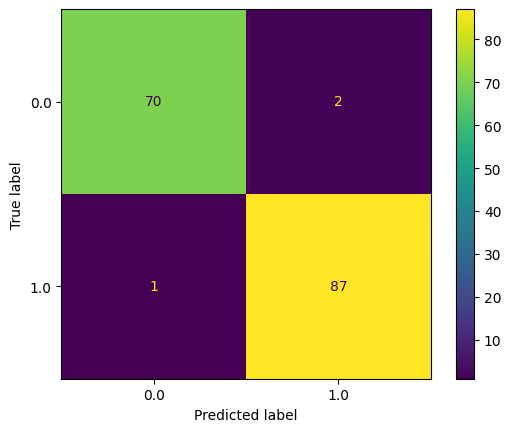

In [275]:
test_ds = tactile_ds.reshape(tactile_ds.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(test_ds, grasp_outcomes_ds, test_size=0.2, random_state=0)

model_511 = LogisticRegression(random_state=0, max_iter=400)
model_511.fit(X_train, y_train)
model_511_predictions = model_511.predict(X_test)
print(f"Accuracy: {model_511.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_511_predictions, labels=model_511.classes_),
    display_labels=model_511.classes_
).plot()

#### 5.1.2 Raw data (Visual only) + LR

Accuracy: 88.75%


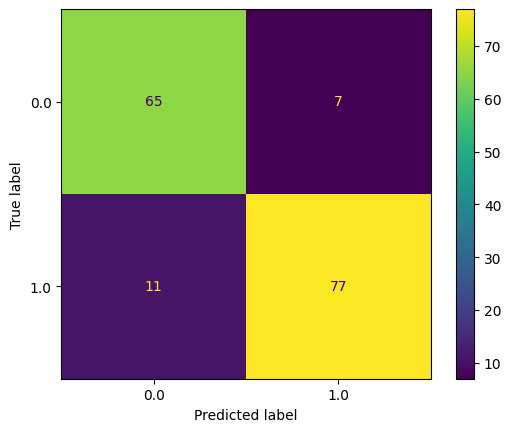

In [276]:
X_train, X_test, y_train, y_test = train_test_split(poses_ds, grasp_outcomes_ds, test_size=0.2, random_state=0)

model_512 = LogisticRegression(random_state=0, max_iter=400)
model_512.fit(X_train, y_train)
model_512_predictions = model_512.predict(X_test)
print(f"Accuracy: {model_512.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_512_predictions, labels=model_512.classes_),
    display_labels=model_512.classes_
).plot()

#### 5.1.3 Raw data (both data) + LR

Accuracy: 98.12%


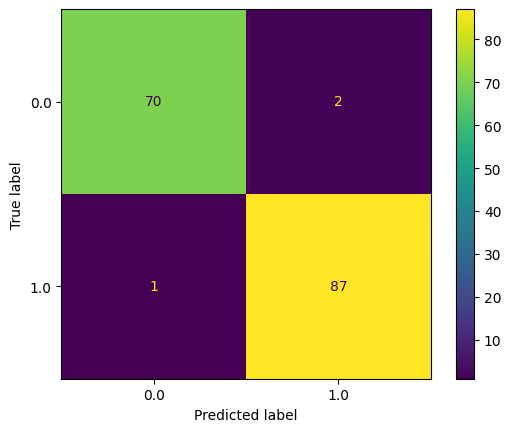

In [277]:
X_train, X_test, y_train, y_test = train_test_split(complete_ds, grasp_outcomes_ds, test_size=0.2, random_state=0)

model_513 = LogisticRegression(random_state=0, max_iter=400)
model_513.fit(X_train, y_train)
model_513_predictions = model_513.predict(X_test)
print(f"Accuracy: {model_513.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_513_predictions, labels=model_513.classes_),
    display_labels=model_513.classes_
).plot()

### 5.2 Principal Component Analysis

Your system may not have enough memory to perform the PCA calculation on the entire input tensor. One solution to this issue is to perform PCA in a mini-batch fashion, where you break down the input tensor into smaller chunks and perform PCA on each chunk separately. Then, you can concatenate the results from each chunk to get the final result.

Defining a mini-batch PCA function:

In [278]:
def pca_multid(tensor, k):
    flatten_tensor = tensor.reshape(tensor.shape[0] * tensor.shape[1], tensor.shape[2])
    pca = PCA(n_components=k)    
    pca.fit(flatten_tensor)
    transformed_tensor = pca.transform(flatten_tensor)
    return transformed_tensor.reshape(tensor.shape[0], tensor.shape[1], k)

def pca_2d(tensor, k):
    pca = PCA(n_components=k)    
    pca.fit(tensor)
    return pca.transform(tensor)

#### 5.2.1 PCA data (tactile only) + LR

In [279]:
pca_tactile_ds = torch.Tensor(np.array([pca_multid(i, k=3) for i in tactile_ds]))
pca_tactile_ds.shape

torch.Size([800, 160, 240, 3])

Accuracy: 93.75%


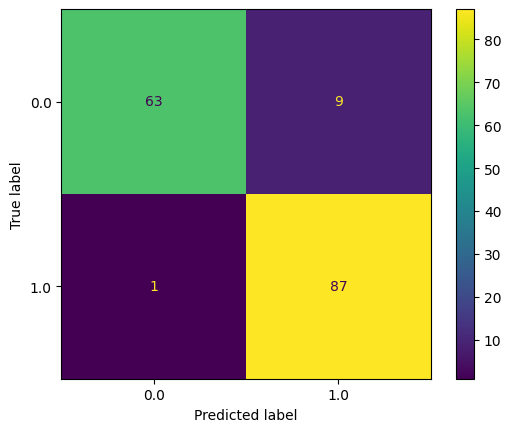

In [280]:
pca_tactile_ds = pca_tactile_ds.reshape(pca_tactile_ds.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(pca_tactile_ds, grasp_outcomes_ds, test_size=0.2, random_state=0)

model_521 = LogisticRegression(random_state=0, max_iter=400)
model_521.fit(X_train, y_train)
model_521_predictions = model_521.predict(X_test)
print(f"Accuracy: {model_521.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_521_predictions, labels=model_521.classes_),
    display_labels=model_521.classes_
).plot()

#### 5.2.2 PCA data (visual only) + LR

In [281]:
pca_poses_ds = torch.Tensor(pca_2d(poses_ds, 3))
pca_poses_ds.shape

torch.Size([800, 3])

Accuracy: 93.75%


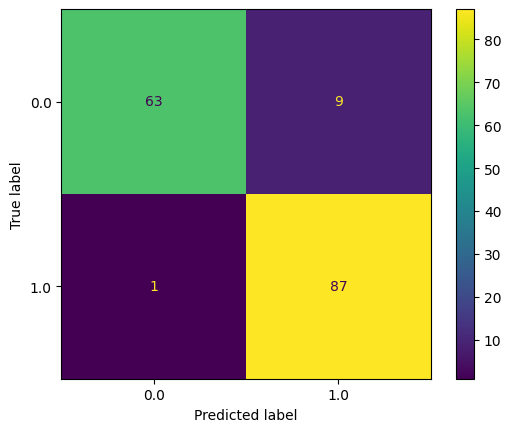

In [282]:
X_train, X_test, y_train, y_test = train_test_split(pca_tactile_ds, grasp_outcomes_ds, test_size=0.2, random_state=0)

model_522 = LogisticRegression(random_state=0, max_iter=400)
model_522.fit(X_train, y_train)
model_522_predictions = model_522.predict(X_test)
print(f"Accuracy: {model_522.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_522_predictions, labels=model_522.classes_),
    display_labels=model_522.classes_
).plot()

#### 5.2.3 PCA data (both data) + LR

In [283]:
pca_complete_ds = torch.cat([pca_tactile_ds.reshape(pca_tactile_ds.shape[0], -1), poses_ds], dim=1)
# pca_complete_ds = torch.nan_to_num(pca_complete_ds)
pca_complete_ds.shape

torch.Size([800, 115206])

Accuracy: 93.75%


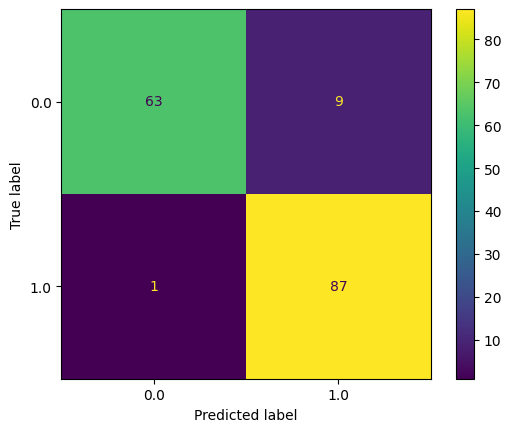

In [284]:
X_train, X_test, y_train, y_test = train_test_split(pca_complete_ds, grasp_outcomes_ds, test_size=0.2, random_state=0)

model_523 = LogisticRegression(random_state=0, max_iter=400)
model_523.fit(X_train, y_train)
model_523_predictions = model_523.predict(X_test)
print(f"Accuracy: {model_523.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_523_predictions, labels=model_523.classes_),
    display_labels=model_523.classes_
).plot()

#### Define convolutional neural network for feature extraction

In [285]:
# A simple convolutional neural network that extracts features from an input tensor
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = nn.functional.relu(x)
        
        return x

#### 5.3.1 CNN data (tactile only) + LR

Accuracy: 97.50%


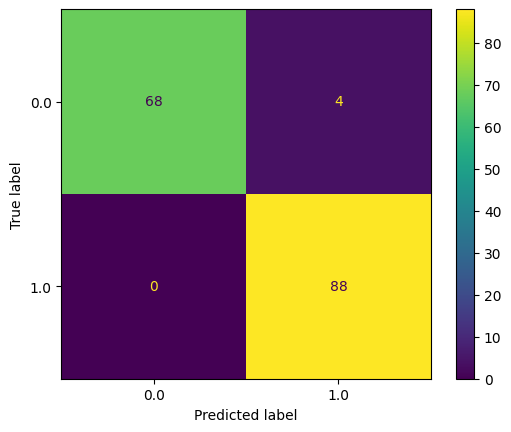

In [286]:
# Preprocess data using CNN feature extraction
cnn_model = FeatureExtractorCNN()
cnn_output = cnn_model(tactile_ds.permute(0,3,1,2).float()).permute(0,1,2,3)
# cnn_output = normalize(cnn_output)
cnn_output = cnn_output.reshape(cnn_output.shape[0], -1)
# cnn_output = torch.nan_to_num(cnn_output)

X_train, X_test, y_train, y_test = train_test_split(cnn_output.detach().numpy(), grasp_outcomes_ds, test_size=0.2, random_state=0)

model_531 = LogisticRegression(random_state=0, max_iter=400)
model_531.fit(X_train, y_train)
model_531_predictions = model_531.predict(X_test)
print(f"Accuracy: {model_531.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_531_predictions, labels=model_531.classes_),
    display_labels=model_531.classes_
).plot()

#### 5.3.2 CNN data (visual only) + LR

Accuracy: 88.75%


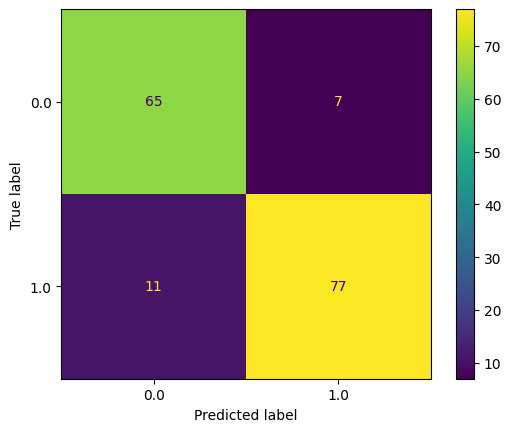

In [287]:
cnn_model532 = FeatureExtractorCNN()
# cnn_output532 = normalize(poses_ds)
# cnn_output532 = cnn_output532.reshape(cnn_output532.shape[0], -1)
cnn_output532 = poses_ds.reshape(poses_ds.shape[0], -1)
# cnn_output532 = torch.nan_to_num(cnn_output532)

X_train, X_test, y_train, y_test = train_test_split(cnn_output532.detach().numpy(), grasp_outcomes_ds, test_size=0.2, random_state=0)

model_532 = LogisticRegression(random_state=0, max_iter=400)
model_532.fit(X_train, y_train)
model_532_predictions = model_532.predict(X_test)
print(f"Accuracy: {model_532.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_532_predictions, labels=model_532.classes_),
    display_labels=model_532.classes_
).plot()

#### 5.3.3 CNN data (both data) + LR

Accuracy: 97.50%


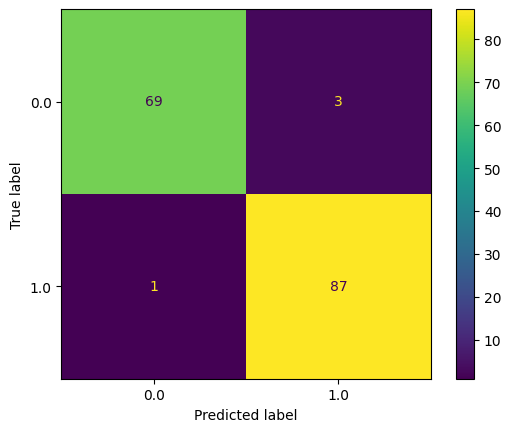

In [288]:
# We simply combine the cnn-processed tactile data (from Section 5.3.1) with the visual data
cnn_complete_ds = torch.cat([cnn_output.reshape(cnn_output.shape[0], -1), cnn_output532], dim=1)

cnn_model533 = FeatureExtractorCNN()
# cnn_output533 = normalize(cnn_complete_ds)
# cnn_output533 = cnn_output532.reshape(cnn_output533.shape[0], -1)
cnn_output533 = cnn_complete_ds.reshape(cnn_complete_ds.shape[0], -1)
# cnn_output533 = torch.nan_to_num(cnn_output533)

X_train, X_test, y_train, y_test = train_test_split(cnn_output533.detach().numpy(), grasp_outcomes_ds, test_size=0.2, random_state=0)

model_533 = LogisticRegression(random_state=0, max_iter=400)
model_533.fit(X_train, y_train)
model_533_predictions = model_533.predict(X_test)
print(f"Accuracy: {model_533.score(X_test, y_test)*100:.2f}%")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, model_533_predictions, labels=model_533.classes_),
    display_labels=model_533.classes_
).plot()